In [1]:
#########################
###  Import Thingies  ###
#########################

import numpy as np
import math
from math import cos
from math import sin
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import os
import re
from tqdm import tqdm
import scipy
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy.ndimage.interpolation import shift
#%matplotlib inline
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
#from moviepy.editor import *
#from PIL import Image
#from glob import glob






C:\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Python37\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Python37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
#####################
###  Import Data  ###
#####################

#45s timing
genotype = 'gr5a-chrimsonvk'  
condition = '20s foodspots laser'

#date_folder = '20190228'
experimentA = '2021_20s_laser'
#experimentB = 'exp-20190228-161356'

# date_folder2 = '20190320'
# experimentB = 'exp-20190320-134948'

# date_folder3 = '20190321'
# experimentC = 'exp-20190321-123401'

# date_folder4 = '20190325'
# experimentE = 'exp-20190325-145606'
# experimentF = 'exp-20190325-151739'
# experimentG = 'exp-20190325-155237'

#Path = 'Z:/data/Ashley2/foraging/' + str(date_folder) + '/' + str(experimentA)+ '/'

Path = 'Z:/trc/data/Ashley2/foraging/'  + str(experimentA)+ '/'
#Path2 = 'Z:/data/Ashley2/foraging/' + str(date_folder) + '/' + str(experimentB)+ '/'
# Path3 = 'Z:/data/Ashley2/foraging/' + str(date_folder3) + '/' + str(experimentC)+ '/'
# Path4 = 'Z:/data/Ashley2/foraging/' + str(date_folder3) + '/' + str(experimentD)+ '/'
# Path5 = 'Z:/data/Ashley2/foraging/' + str(date_folder4) + '/' + str(experimentE)+ '/'
# Path6 = 'Z:/data/Ashley2/foraging/' + str(date_folder4) + '/' + str(experimentF)+ '/'
# Path7 = 'Z:/data/Ashley2/foraging/' + str(date_folder4) + '/' + str(experimentG)+ '/'


SavePath = 'C:/Users/ashsm/Documents/Stanford/timing-analysis/' + str(condition) + '-graphs/'

if os.path.exists(SavePath):
    print('folder there')
else:
    os.makedirs(SavePath)
    

    
print(Path)
#dirNames = os.listdir(Path)
#dirNames = os.listdir(Path) + os.listdir(Path2)+ os.listdir(Path3)+ os.listdir(Path4)+ os.listdir(Path5)+ os.listdir(Path6)+ os.listdir(Path7)
dirNames = os.listdir(Path)

Pathlist = [Path]
print(Pathlist)
print(dirNames)




folder there
Z:/trc/data/Ashley2/foraging/2021_20s_laser/
['Z:/trc/data/Ashley2/foraging/2021_20s_laser/']
['exp-20210507-153541', 'gate_data.txt', 'metadata.txt', 'raw_gate_data.txt', 'trial-1-20210503-154505', 'trial-2-20210503-154720', 'trial-3-20210503-162116', 'trial-4-20210503-162609', 'trial-5-20210503-164133']


In [3]:
class Trial:
    def __init__ (self, dirName):
        #this sets up the path (fname) and calls the following classes
        self.cam = Cam(os.path.join(dirName, 'cam.txt'))
        self.cnc = Cnc(os.path.join(dirName, 'cnc.txt'))
        
        if os.path.exists(os.path.join(dirName, 'opto.txt')): #in case there is no opto file
            self.opto = Opto(os.path.join(dirName, 'opto.txt'))
        
class Cam:
    def __init__ (self, fname):
        print(fname)
        self.tvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(0,))
        self.xvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(1,))
        self.yvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(2,))
        #self.pvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(1,), dtype=bool)
        self.avec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(3,))

class Cnc:
    def __init__ (self, fname):
        print(fname)
        self.tvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(0,))
        self.xvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(1,))
        self.yvec = np.genfromtxt(fname, delimiter=',',skip_header=1,usecols=(2,))
        
class Opto:
    def __init__ (self, fname):
        print(fname)
        #instead of genfromtext use a line by line reader
        with open(fname) as f:
            lines = f.read().split('\n')
            
            self.optodata = []
            self.label = []
            self.xfood = []
            self.yfood = []
            self.foodtime = []
            self.ledtime = []
            self.ledstatus = []
            for i in range(len(lines)):
                new_line = lines[i].split(',')  #split up each element in a line 
                self.optodata.append(new_line)
                self.label.append(new_line[0])
                if self.label[i] == 'food':  #make food lists
                    self.foodtime.append(float(new_line[1]))  #need to convert strings to floats
                    self.xfood.append(float(new_line[2]))
                    self.yfood.append(float(new_line[3]))
                if self.label[i] == 'led': # make led lists
                    self.ledtime.append(float(new_line[1]))
                    self.ledstatus.append(new_line[2])



## For importing files in correct order:
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    return [tryint(c) for c in re.split('([0-9]+)', s)]

def sort_nicely(x):
    x.sort(key=alphanum_key)


##if getting data from multiple folders  
each_path_dir = []
for path in Pathlist:
    each_dir = os.listdir(path)
    each_path_dir.append(each_dir)
print(each_path_dir)
print(len(each_path_dir))

dirNames = []
trials = []
for i in range(len(each_path_dir)):
    each_dirNames = [x for x in each_path_dir[i] if 'trial' in x]
    each_trials = ([Trial(os.path.join(Pathlist[i], dirName)) for dirName in each_dirNames])
#     dirNames.append(each_dirNames)
#     trials.append(each_trials)
    dirNames = dirNames + each_dirNames
    trials = trials + each_trials

#if getting data from single folder
# dirNames = [x for x in dirNames if 'trial' in x]
# sort_nicely(dirNames)
# trials = ([Trial(os.path.join(Path, dirName)) for dirName in dirNames])
print(trials)

#get metadata
metafname = os.path.join(Path, 'metadata.txt')
if os.path.exists(metafname): #in case there is no metadata
    with open(metafname) as f:
        metadata = f.read()
else: metadata = 'Not Specified' #so I can still add to dictionary
print(metadata)


[['exp-20210507-153541', 'gate_data.txt', 'metadata.txt', 'raw_gate_data.txt', 'trial-1-20210503-154505', 'trial-2-20210503-154720', 'trial-3-20210503-162116', 'trial-4-20210503-162609', 'trial-5-20210503-164133']]
1
Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-1-20210503-154505\cam.txt
Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-1-20210503-154505\cnc.txt
Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-1-20210503-154505\opto.txt
Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-2-20210503-154720\cam.txt
Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-2-20210503-154720\cnc.txt
Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-2-20210503-154720\opto.txt
Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-3-20210503-162116\cam.txt
Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-3-20210503-162116\cnc.txt
Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-3-20210503-162116\opto.txt
Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-4-20210503-162609\cam.txt
Z:/trc/data/Ashley2/

C:\Python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: genfromtxt: Empty input file: "Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-5-20210503-164133\cam.txt"
  del sys.path[0]
C:\Python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: genfromtxt: Empty input file: "Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-5-20210503-164133\cam.txt"
  
C:\Python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: genfromtxt: Empty input file: "Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-5-20210503-164133\cam.txt"
  from ipykernel import kernelapp as app
C:\Python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: genfromtxt: Empty input file: "Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-5-20210503-164133\cam.txt"


Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-5-20210503-164133\cnc.txt
Z:/trc/data/Ashley2/foraging/2021_20s_laser/trial-5-20210503-164133\opto.txt
[<__main__.Trial object at 0x0000025FFF10ECC8>, <__main__.Trial object at 0x0000025FFF10EB48>, <__main__.Trial object at 0x0000025FFF0FB288>, <__main__.Trial object at 0x0000025FFF139808>, <__main__.Trial object at 0x0000025F88A3BF88>]
{
  "user": "ashley-timing",
  "age": "4-26 collect 0-2 days, 4-31 starve atr",
  "timezone": "20s foodspots no returns",
  "genotype": "gr5a/+;chrimson/+"
}{
  "food radius (mm)": 0.005,
  "distance from center requirement (m)": 0.03,
  "min off time (s)": 20,
  "max on time (s)": 1.0,
  "keep light on for full on time": "yes"
}


In [4]:
#################################################
### Create fly class and pull from trial data ###
#################################################

class Fly:
    def __init__ (self,trial,time_res=0.01,sigma=0):
        if np.any(trial.cam.xvec):  #xvec was pvec before
            # Get cam data (only time points where pvec is true, aka fly is present)
            #there is no longer an indicator if the fly is there
            #camt = trial.cam.tvec[trial.cam.pvec]
            camt = trial.cam.tvec
            #Interpolate
#             cama = interp1d(camt, trial.cam.avec[trial.cam.pvec],kind='nearest')
#             camx = interp1d(camt, trial.cam.xvec[trial.cam.pvec])
#             camy = interp1d(camt, trial.cam.yvec[trial.cam.pvec])
            cama = interp1d(camt, trial.cam.avec,kind='nearest')
            camx = interp1d(camt, trial.cam.xvec)
            camy = interp1d(camt, trial.cam.yvec)
            # Get cnc data
            cncx = interp1d(trial.cnc.tvec, trial.cnc.xvec)
            cncy = interp1d(trial.cnc.tvec, trial.cnc.yvec)
            tmin = max(camt[0], trial.cnc.tvec[0])
            tmax = min(camt[-1], trial.cnc.tvec[-1])
            
            # Pull from interpolated data at chosen time resolution, and add camera and cnc positions
            self.t = np.arange(tmin, tmax, time_res)
            self.x = camx(self.t) + cncx(self.t)
            self.y = camy(self.t) + cncy(self.t)
            self.a = cama(self.t)
            # Unwrap angles and rotate
            self.angleUnwrapper()
            #self.a=angleChangeOrigin(self.a)
            self.a = 90-self.a #rotate angles 90deg to change ellipse fitting defined angles
            #self.a = self.a+90 #flip angle horizontally due to camera flip
            # Smooth if asked to
            if sigma is not 0:
                self.x = scipy.ndimage.filters.gaussian_filter1d(self.x,sigma)
                self.y = scipy.ndimage.filters.gaussian_filter1d(self.y,sigma)
                self.a = scipy.ndimage.filters.gaussian_filter1d(self.a,sigma)
            self.tvid = self.t - camt[0] #for video debugging
            self.velocity()
            
##-----> ADD IF CONDITION HERE IN CASE THERE IS NO OPTO
        #elif np.any(trial.opto.xfood):
            self.optofoodx = trial.opto.xfood
            self.optofoody = trial.opto.yfood
            self.ledtime = trial.opto.ledtime # probably should not be the same name--fix later
            
        else:
            self.t = None
            self.x = None
            self.y = None
            self.a = None
            self.v = None
            self.tvid = None    
            self.optofoodx = None
            self.optofoody = None
            self.ledtime = None
    def angleUnwrapper(self):
        jumpThresh=150
        angles=[]
        angle_offset=0
        for k, angle in enumerate(self.a):
            if k == 0:
                angles.append(angle)
                continue
            angle += angle_offset
            if angles[-1]-angle > jumpThresh:
                angle_offset += 180
                angle += 180
            elif angle-angles[-1] > jumpThresh:
                angle_offset -= 180
                angle -= 180
            angles.append(angle)
        self.a = np.array(angles)
    def velocity(self):
        x1 = self.x
        y1 = self.y
        a1 = self.a
        x2 = shift(x1,-1,cval=np.NaN)
        y2 = shift(y1,-1,cval=np.NaN)
        a2 = shift(a1,-1,cval=np.NaN)
        # Calculate velocity
        dist = (((x2-x1)**2)+((y2-y1)**2))**0.5
        self.v = dist[:-2]
#         # Calculate angle of velocity
#         angle = np.rad2deg(np.arctan2((y2-y1),(x2-x1))%(2*np.pi)) 
#         angle = angle[:-2]
        # Calculate angular velocity
        angular_velocity = a2-a1
        self.av = angular_velocity[:-2]

class FlyArrow:
    def __init__ (self,fly,scale,flip=False):
        if np.any(fly.x):
            if flip is True:
                fly.a = fly.a + 180
            self.x1 = fly.x+np.cos(fly.a*np.pi/180)*scale
            self.x2 = fly.x-np.cos(fly.a*np.pi/180)*scale
            self.y1 = fly.y-np.sin(fly.a*np.pi/180)*scale
            self.y2 = fly.y+np.sin(fly.a*np.pi/180)*scale
        else:
            self.x1 = None
            self.x2 = None
            self.y1 = None
            self.y2 = None            



In [16]:
fly1 = Fly(trials[0])

[0.35117469 0.35117318 0.35117013 ... 0.36444925 0.36444903 0.36444888]


<Figure size 432x288 with 0 Axes>

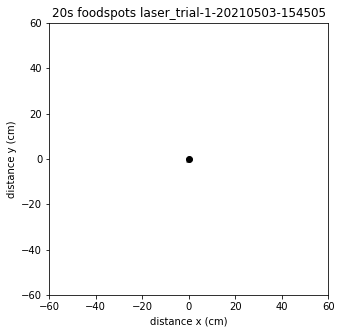

<Figure size 432x288 with 0 Axes>

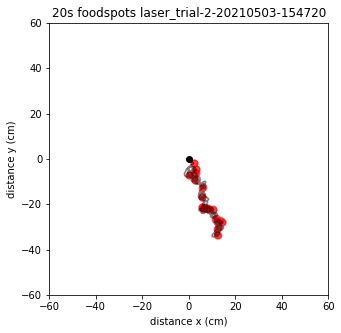

<Figure size 432x288 with 0 Axes>

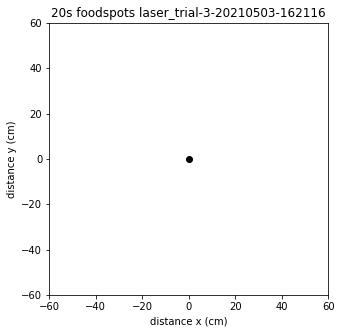

<Figure size 432x288 with 0 Axes>

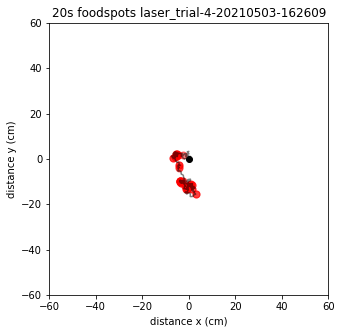

In [5]:
######   MAKE INIDIVIDUAL LINE PLOTS

#plot lines of trajectories and scatter foodspots
flies = [Fly(trial, sigma=3) for trial in trials]
print(flies[3].x)
for fly_index in range(len(flies)): 
    if flies[fly_index].x is not None: 
        fig1 = plt.figure()
        fig1 = plt.figure(figsize=(5,5))
        ax1 = fig1.add_subplot(111)
#         plt.xlim(-.6,.6)
#         plt.ylim(-.6,.6)
#         plt.yticks(np.arange(-.6,.6, step = .1))
#         plt.xticks(np.arange(-.6,.6, step = .1))
        plt.xlim(-60,60)
        plt.ylim(-60,60)
#         plt.yticks(np.arange(60,60, step = 10))
#         plt.xticks(np.arange(60,60, step = 10))
        plt.xlabel("distance x (cm)")
        plt.ylabel("distance y (cm)")
        centerx = flies[fly_index].x[0]
        centery = flies[fly_index].y[0]
        plt.plot((flies[fly_index].x - centerx)*100, (flies[fly_index].y-centery)*100, color = 'black', alpha = .5)
        plt.title(str(condition)+ '_' + str(dirNames[fly_index]))
        plt.scatter((flies[fly_index].optofoodx-centerx)*100, (flies[fly_index].optofoody-centery)*100, s = 50, color = 'red', alpha = .5)
        plt.scatter(0, 0, color = 'black')
    fig1.savefig(os.path.join(SavePath, str(genotype)+ '_' + str(condition) + 'fly ' + str(fly_index + 1) + 'PATH.png'))
    plt.show()





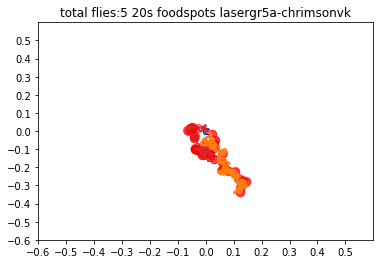

In [8]:
######   MAKE LINE PLOTS OVERLAY

#plot lines of trajectories and scatter foodspots
flies = [Fly(trial, sigma=3) for trial in trials]
fig1 = plt.figure()
for fly_index in range(len(flies)):     
    if flies[fly_index].x is not None:
        #ax1 = fig1.add_subplot(111)
        plt.xlim(-.6,.6)
        plt.ylim(-.6,.6)
        plt.yticks(np.arange(-.6,.6, step = .1))
        plt.xticks(np.arange(-.6,.6, step = .1))
        centerx = flies[fly_index].x[0]
        centery = flies[fly_index].y[0]
        plt.plot(flies[fly_index].x - centerx, flies[fly_index].y-centery)

        plt.scatter(flies[fly_index].optofoodx-centerx, flies[fly_index].optofoody-centery, s = 70, color = 'red', alpha = .5)
        plt.scatter(0, 0, color = 'blue')
plt.title('total flies:' + str(fly_index+1) + ' ' + str(condition) + str(genotype))    
fig1.savefig(os.path.join(SavePath, str(genotype)+ '_' + str(condition) + 'fly ' + str(fly_index + 1) + 'OVERLAY-PATHs.png'))
plt.show()




In [11]:
print(flies[1].optofoodx) #x location for food (y = optofoody)
print(flies[1].ledtime) #time led turns on

[0.377230952232553, 0.3770979392811221, 0.35781211693168696, 0.3577891571898869, 0.38764088204118424, 0.38774748618736926, 0.3849189285639691, 0.38624687602392993, 0.3843906936425256, 0.38296203880008234, 0.41921052500961514, 0.41511283623053075, 0.41484394959395127, 0.41493401808875524, 0.4291729385504706, 0.42929074706891934, 0.43822222131180705, 0.4361349416896934, 0.417756627267136, 0.418372850428529, 0.4122057508021769, 0.41323818132139256, 0.46197294909176867, 0.4612896713239369, 0.47348494820581793, 0.47116993075460367, 0.49971852684546453, 0.49902507296594556, 0.48887056333033485, 0.4838815236850367, 0.4816927059910864, 0.47763230790614086, 0.48030215940166554, 0.4789824665933353]
[1620082094.3148382, 1620082095.3168304, 1620082115.318722, 1620082116.321454, 1620082136.322687, 1620082137.3237455, 1620082157.3244948, 1620082158.3273923, 1620082178.3280118, 1620082179.3321297, 1620082199.3336506, 1620082200.3388743, 1620082220.3437593, 1620082221.3456042, 1620082241.3501086, 1620

In [66]:
print(flies[fly_index].t)
print(flies[1].t[1] - flies[1].t[0])

[1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.62008191e+09 1.62008191e+09 1.62008191e+09
 1.62008191e+09 1.620081

In [42]:
##are any foodspots within foodspot radius apart?

flies = [Fly(trial, sigma=3) for trial in trials]
all_fly_foodspot_distances_matrix = []
for fly_index in range(len(flies)):  
    distances_matrix = []
    if flies[fly_index].optofoodx is not None and len(flies[fly_index].optofoodx) > 0:
        flyx = np.array(flies[fly_index].x)
        flyy = np.array(flies[fly_index].y)
        optox = np.array(flies[fly_index].optofoodx)
        optoy = np.array(flies[fly_index].optofoody)
        
        for opto_index in range(len(flies[fly_index].optofoodx)):
            current_optox = flies[fly_index].optofoodx[opto_index]
            current_optoy = flies[fly_index].optofoody[opto_index]
            distances = np.sqrt((current_optox - optox)**2 + (current_optoy - optoy)**2)
            distances_matrix.append(distances)
    all_fly_foodspot_distances_matrix.append(distances_matrix)

(5,)
(34, 34)
max distance [0.33397193 0.33378755 0.29345056 0.29308506 0.30417864 0.3040622
 0.28929923 0.28854057 0.26183848 0.26154142 0.22200227 0.21910649
 0.18048588 0.18044037 0.20375161 0.20386432 0.20837462 0.20900388
 0.20236665 0.20304844 0.19790064 0.1985012  0.22122152 0.22145661
 0.26068681 0.26463555 0.28708341 0.28782284 0.27628239 0.27640281
 0.30642276 0.3066463  0.33397193 0.33377352]
median distance [0.20270755 0.20250222 0.15937498 0.15900156 0.17329618 0.17319069
 0.15753255 0.15692338 0.12899588 0.1285224  0.09432156 0.09011601
 0.10876591 0.10880347 0.09147969 0.09158    0.08634981 0.08695484
 0.09193103 0.09250654 0.09485269 0.09378287 0.07230127 0.0722684
 0.07576502 0.07215556 0.10197678 0.10211451 0.08915093 0.08670665
 0.10982476 0.10892322 0.13439633 0.1339834 ]


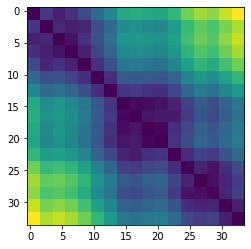

(51, 51)
max distance [0.18025659 0.19521835 0.19499627 0.18513678 0.1857411  0.1861361
 0.18586369 0.18632522 0.18610627 0.1884591  0.18786099 0.19605395
 0.19502523 0.14557965 0.14666842 0.13808057 0.1391372  0.14614054
 0.14614901 0.15887975 0.15877998 0.16260861 0.16289204 0.15113659
 0.15044684 0.16931204 0.16854277 0.14627684 0.14691491 0.19605395
 0.19585368 0.12293879 0.1228444  0.12079913 0.11954098 0.12161979
 0.1203416  0.12315801 0.12116297 0.12431766 0.12389326 0.12980373
 0.13018421 0.15239927 0.15065105 0.15075066 0.15145921 0.15030233
 0.15016583 0.15350035 0.15338888]
median distance [0.11613188 0.12126545 0.12119798 0.10775207 0.1083546  0.11046178
 0.11010047 0.11388852 0.11372553 0.11643692 0.11588449 0.12389326
 0.1235494  0.07187243 0.07338508 0.06200071 0.06312046 0.03124648
 0.03133533 0.03942936 0.03934982 0.04276147 0.04293079 0.04522873
 0.04571608 0.05536121 0.05495555 0.04535114 0.04748743 0.08116026
 0.08087075 0.03907426 0.03859485 0.04868616 0.04941746 0

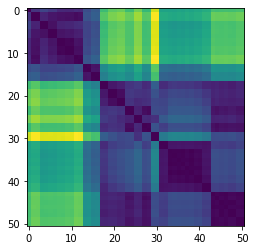

In [46]:
# #these plots are the distances from each foodspot to eachother (diagonal is foodspot to itself)

# print(np.shape(all_fly_foodspot_distances_matrix))
# for fly_index in range(len(all_fly_foodspot_distances_matrix)):
#     if len(all_fly_foodspot_distances_matrix[fly_index]) > 0:
#         print(np.shape(all_fly_distances_matrix[fly_index]))
#         print('max distance', np.max(all_fly_distances_matrix[fly_index], axis = 1))
#         print('median distance', np.median(all_fly_distances_matrix[fly_index], axis = 1))
#         plt.imshow(all_fly_distances_matrix[fly_index])
#         plt.show()
#         #print(all_fly_distances_matrix[fly_index])
# #         for distance in all_fly_distances_matrix[fly_index]:
# #             if distance < foodspot_radius

In [33]:
## make empty dictionary to store relevant analysis data

foraging_dict = {}


#foraging parameters from https://elifesciences.org/articles/19920

#1. Total duration of visits (2.5mm from center of foodspot)
#2. Number of foodspot visits 
#3. rate of food encounters (sum of all food encounters/time spent walking otuside patches) 
#4. average duration of foodspot visits (total duration/number of visits)
#5. average minumum distance from foodspot
#6. body speed during yeast visits
#7. angular speed during yeast visits
#8. average distance traveled to next foodspot
#9. speed outside foodspots



#1. total duration of visits
#2. Number of foodspot visits
#I want to know how long the fly stayed within 2.5mm of the foodspot (x,y) (2.5mm is VERY small, maybe I want bigger)
# if location of fly is < x +/-2.5 and < y +/- 2.5 (since x,y is in meters I think I'll try 1cm to start (.01))
# sum the time?
# ignore if the foodspot goes away or not for now. (just asking are they in the area)
foodspot_radius = .005 #.01 is 1cm
flies = [Fly(trial, sigma=3) for trial in trials]
print(len(flies))
all_fly_foodspot_time = []
all_fly_foodspot_count = []
all_fly_foodspot_bool = []
all_fly_foodspot_avg_dist = []
all_min_distance = []
all_avg_min_distance = []
for fly_index in range(len(flies)):  
    all_foodspot_time = []
    foodspot_bool = []
    if flies[fly_index].optofoodx is not None and len(flies[fly_index].optofoodx) > 0:
        flyx = np.array(flies[fly_index].x)
        flyy = np.array(flies[fly_index].y)
        optox = np.array(flies[fly_index].optofoodx)
        optoy = np.array(flies[fly_index].optofoody)
        distance_matrix = np.sqrt(
            (flyx[:, np.newaxis] - optox[np.newaxis, :]) ** 2 +
            (flyy[:, np.newaxis] - optoy[np.newaxis, :]) ** 2
        )
        in_foodspot_bool = distance_matrix < foodspot_radius
        ## time between x is .01s (framerate)
        total_time_in_foodspot = np.sum(in_foodspot_bool, axis=0)*.01
        #all_foodspot_time.append(total_time_in_foodspot)
        print(distance_matrix)
        min_distance = np.min(distance_matrix, axis=1)
        all_fly_foodspot_avg_dist.append(min_distance.mean())
#         for opto_index in range(len(flies[fly_index].optofoodx)):
#             optox = flies[fly_index].optofoodx[opto_index]
#             optoy = flies[fly_index].optofoody[opto_index]
#             #how do I do this for each point without it taking forever? 
#             #also how do i get the times? Do I want total time or consectutive time (fly not allowed to leave and come back)
#             #I know it takes x,y at specific framerate so I can use that for time
#             #I think total time in vicinity to start and then consecutive time (a per bout time)
#             #maybe I can look for when it is bigger and then smaller than this equation? and get those index points
#             #possibly filter first by looking for points less than square aroud foodspot just in x then do equation on those points?
#             distance_from_foodspot = np.sqrt((flyx - optox) ** 2 + (flyy - optoy) **2 )
#             #make boolean if value is < foodspot radius
#             in_foodspot_bool = distance_from_foodspot < foodspot_radius
#             ## time between x is .01s (framerate)
#             total_time_in_foodspot = np.sum(in_foodspot_bool)*.01
#             all_foodspot_time.append(total_time_in_foodspot)
        total_foodspots = len(flies[fly_index].optofoodx)
        #foodspot_bool.append(in_foodspot_bool)
    else:
        #all_foodspot_time.append(np.nan)
        total_time_in_foodspot = np.nan
        total_foodspots = 0
        min_distance = np.nan
        in_foodspot_bool = []
        
    #all_fly_foodspot_time.append(all_foodspot_time)
    all_fly_foodspot_time.append(total_time_in_foodspot)
    all_fly_foodspot_count.append(total_foodspots)
    all_fly_foodspot_bool.append(in_foodspot_bool)
    all_min_distance.append(min_distance)
    all_avg_min_distance.append(all_fly_foodspot_avg_dist)
    
    

5
[[0.0279883  0.02804788 0.0696351  ... 0.3313591  0.35840668 0.35815606]
 [0.02798967 0.02804924 0.06963532 ... 0.33135988 0.35840743 0.3581568 ]
 [0.02799194 0.0280515  0.06963573 ... 0.33136121 0.3584087  0.35815807]
 ...
 [0.3364468  0.33625097 0.29369148 ... 0.03909553 0.01992229 0.01862798]
 [0.33646367 0.33626787 0.29371426 ... 0.03907436 0.01986973 0.01857587]
 [0.33647246 0.33627667 0.29372615 ... 0.03906329 0.01984224 0.01854861]]
[[0.03068771 0.05924081 0.05873948 ... 0.11836382 0.12014564 0.12006744]
 [0.03068607 0.05923917 0.05873784 ... 0.11836448 0.12014636 0.12006816]
 [0.03068283 0.05923589 0.05873456 ... 0.11836568 0.12014768 0.12006948]
 ...
 [0.14723522 0.16151998 0.16130331 ... 0.01543891 0.01033289 0.01047174]
 [0.14723505 0.16151979 0.16130312 ... 0.01543867 0.01033266 0.01047151]
 [0.14723491 0.16151963 0.16130296 ... 0.01543848 0.01033247 0.01047132]]


In [101]:
# print(np.shape(all_fly_foodspot_time))
print(all_fly_foodspot_time)

for i in range(len(all_fly_foodspot_time)):
    print(i)
    print(type(all_fly_foodspot_time[i]))
    if type(all_fly_foodspot_time[i]) == float: # and all_fly_foodspot_time[i] == 'nan':
        print('nan', i)
#     print(i)
#     print(len(i))

[nan, array([ 5.6 ,  5.61,  8.32,  7.77,  8.44,  8.29, 13.75, 13.19,  9.18,
        8.8 ,  6.01,  4.16, 10.13, 10.16, 26.48, 26.39, 17.75, 18.83,
       35.25, 36.2 , 27.76, 28.9 ,  4.99,  5.43,  5.32,  4.5 ,  7.  ,
        7.96,  9.36, 14.5 ,  8.5 ,  7.29, 12.6 , 13.18]), nan, array([ 19.85,  91.67,  91.85,  26.76,  27.23,  33.86,  33.65,  62.7 ,
        58.69,  77.96,  74.44,  75.8 ,  81.32,  21.09,  17.97,  11.05,
        16.55,  14.93,  14.99,  36.13,  36.37,  32.88,  32.79,  79.63,
        55.31,  33.73,  34.82, 132.57, 106.84,   5.04,   5.13,  33.61,
        26.13,  99.71,  98.88,  95.32,  99.77,  99.36,  95.41, 105.4 ,
       105.26,  79.22,  74.27, 103.83, 135.33, 103.05, 105.7 ,  96.04,
        97.52, 118.56, 118.51]), nan]
0
<class 'float'>
nan 0
1
<class 'numpy.ndarray'>
2
<class 'float'>
nan 2
3
<class 'numpy.ndarray'>
4
<class 'float'>
nan 4


(5,)
[nan, array([ 4.52,  4.55,  1.9 ,  1.92,  6.18,  6.17, 11.09, 11.08,  3.39,
        3.6 ,  1.34,  1.53,  5.93,  6.  , 10.14, 10.07,  5.86,  6.44,
       13.84, 14.09, 11.92, 11.97,  2.47,  2.6 ,  1.65,  1.19,  3.35,
        3.61,  3.34,  2.6 ,  3.5 ,  3.21,  7.28,  7.34]), nan, array([17.79, 16.96, 16.92, 17.49, 17.53, 14.35, 14.35, 50.33, 50.13,
       50.7 , 50.71, 18.6 , 19.62, 16.54, 16.41,  8.95,  8.94, 13.76,
       13.31, 10.  ,  9.99, 21.52, 21.44, 39.43, 35.38, 14.05, 11.79,
       17.33, 27.14,  3.76,  3.83, 15.93, 10.29, 73.56, 68.25, 79.84,
       68.72, 83.57, 73.48, 84.17, 83.9 ,  6.79,  6.67, 81.33, 81.12,
       83.54, 83.23, 65.45, 65.64, 63.6 , 64.12]), nan]
5.755000000000001
37.10294117647059


C:\Python37\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Text(0.5, 1.0, "Time flies spend in each foodspot \n (some may be the same foodspot the fly returned to) \n Mean time in foodspots (s): ['5.76', '37.10']")

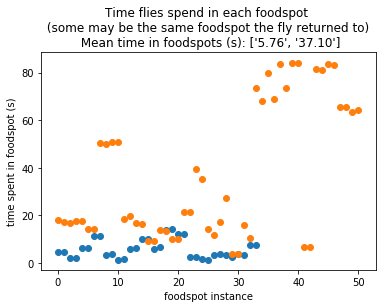

In [34]:
#4. average duration of foodspot visits (total duration/number of visits) 
# not currently stored, but could be
print(np.shape(all_fly_foodspot_time))
print(all_fly_foodspot_time)
all_mean = []
for fly in range(len(all_fly_foodspot_time)):
    if type(all_fly_foodspot_time[fly]) != float and len(all_fly_foodspot_time[fly]) > 0:
        plt.scatter(range(len(all_fly_foodspot_time[fly])), all_fly_foodspot_time[fly])
        mean= np.mean(all_fly_foodspot_time[fly])
        print(mean)
        #plt.scatter(mean)
        all_mean.append("{:.2f}".format(mean))
plt.xlabel("foodspot instance")
plt.ylabel("time spent in foodspot (s)")
plt.title(f"Time flies spend in each foodspot \n (some may be the same foodspot the fly returned to) \n Mean time in foodspots (s): {all_mean}")

In [35]:
for i in range(len(all_fly_foodspot_bool)):
    if all_fly_foodspot_count[i] > 0:
        print(np.shape(all_fly_foodspot_bool[i]))
        print(len(all_fly_foodspot_bool[i]))
        #for each time point is there a true?
        #for timepoint_index, foodspot_index in np.shape(all_fly_foodspot_bool[i]):
#         for timepoint_index in range(len(all_fly_foodspot_bool[i])):  
#             if np.sum(np.sum(all_fly_foodspot_bool[i][timepoint_index])) > 0: #considered in multiple foodspots at the same time...
#                 #print(np.sum(np.sum(all_fly_foodspot_bool[i][timepoint_index])))
#                 #print(timepoint_index)
        print('food time', np.sum(np.any(all_fly_foodspot_bool[i], axis = 1)))  #this will give the number of timepoints where the fly is in at least 1 foodspot
#         plt.imshow(all_fly_foodspot_bool[i][5250:5360], cmap = 'gray')
#         plt.show()
#         print('sum', (np.sum(all_fly_foodspot_bool[i], axis = 0)))
#         print(all_fly_foodspot_bool[i])
        
##I could look for every opto column how many TRUE or filter if ture in only one column

(39792, 34)
39792
food time 10415
(86367, 51)
86367
food time 46950


In [192]:
all_fly_foodspot_count

[0, 34, 0, 51, 0]

In [36]:
#3. rate of food encounters (sum of all food encounters/time spent walking otuside patches)
framerate = .01
all_fly_food_encounter_rate = []
for fly_index in range(len(all_fly_foodspot_bool)):
    if all_fly_foodspot_count[fly_index] > 0:
        fly_in_food_time = np.sum(np.any(all_fly_foodspot_bool[fly_index], axis = 1))
        total_time = len(all_fly_foodspot_bool[fly_index])
        time_not_on_food = (total_time - fly_in_food_time)*framerate
        encounter_rate = all_fly_foodspot_count[fly_index]/time_not_on_food
        all_fly_food_encounter_rate.append(encounter_rate)
    else:
        all_fly_food_encounter_rate.append(0)
print(all_fly_food_encounter_rate)

[0, 0.11573680089866223, 0, 0.12938579800593653, 0]


[nan, array([0.0279883 , 0.02798967, 0.02799194, ..., 0.01862798, 0.01857587,
       0.01854861]), nan, array([0.03068771, 0.03068607, 0.03068283, ..., 0.00612497, 0.00612516,
       0.00612533]), nan]


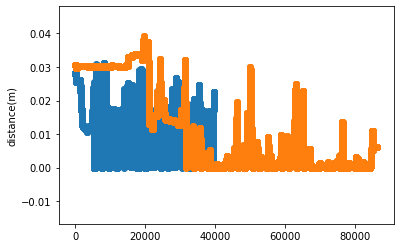

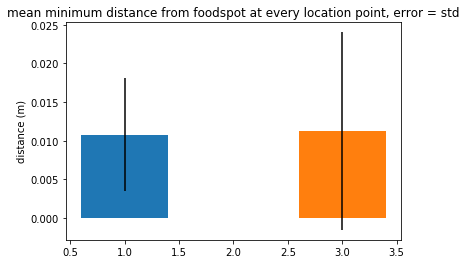

In [37]:
#5. average minumum distance from foodspot

#I want the distance to be an array time rows and foodspot columns per fly 
#then I can look at each row and find minumum and store it and then average across time
## need to change previous bit to look at distance in matrix form
#done in previous cell with new matrix!

print(all_min_distance)  #if no opto encountered then it will be nan

for fly_index in range(len(all_min_distance)):
    if type(all_min_distance[fly_index]) is not float:
        plt.scatter(range(len(all_min_distance[fly_index])), all_min_distance[fly_index])
plt.ylabel("distance(m)")
plt.show()
for fly_index in range(len(all_min_distance)):
    if type(all_min_distance[fly_index]) is not float:
        yerr = np.std(all_min_distance[fly_index])
        plt.errorbar(fly_index, np.mean(all_min_distance[fly_index]), yerr = yerr, color = 'black')
        plt.bar(fly_index, np.mean(all_min_distance[fly_index]))
plt.title("mean minimum distance from foodspot at every location point, error = std")
plt.ylabel("distance (m)")
plt.show()

food 5.421123777983849e-05
no food 0.00010911323848201515
food av 0.020814924900853068
no food av 0.02846006146167657
food 1.3956282337593476e-05
no food 2.3273427954767376e-05
food av 0.014210507194720974
no food av 0.013126419033313302


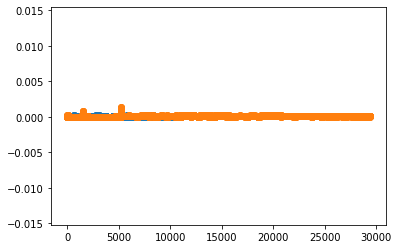

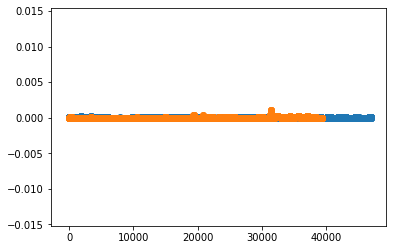

In [38]:
#6. body speed during foodspot visits
#7. angular speed during foodspot visits
#9. speed outside foodspots
# same idea as 6,7 but look where bool is false


#look at bool of when the fly is in the foodspot and find the speed (self.v) angular velocity is (self.av)
flies = [Fly(trial, sigma=3) for trial in trials]
all_fly_in_food_speed = []
all_fly_not_in_food_speed = []
all_fly_in_food_av = []
all_fly_not_in_food_av = []
for fly_index in range(len(flies)):
    fly_in_food_speed = [] #so it makes an empty list for flies that don't have opto
    fly_not_in_food_speed = []
    fly_in_food_av = []
    fly_not_in_food_av = []
    if flies[fly_index].optofoodx is not None and len(flies[fly_index].optofoodx) > 0:
        velocity = np.array(flies[fly_index].v)
        ##the bool is two longer than the velocity because of velocity calculation (code looks like it truncates last two points)
        fly_in_food_speed = np.any(all_fly_foodspot_bool[fly_index][:-2], axis = 1)*velocity #code looks like doesn't use last two points
        fly_in_food_speed = fly_in_food_speed[fly_in_food_speed != 0] #false will be 0 so this will get rid of it
        fly_not_in_food_speed = ~np.any(all_fly_foodspot_bool[fly_index][:-2], axis = 1)*velocity
        fly_not_in_food_speed = fly_not_in_food_speed[fly_not_in_food_speed != 0]
        fly_in_food_av = np.any(all_fly_foodspot_bool[fly_index][:-2], axis = 1)*flies[fly_index].av
        fly_in_food_av = fly_in_food_av[fly_in_food_av !=0]
        fly_not_in_food_av = ~np.any(all_fly_foodspot_bool[fly_index][:-2], axis = 1)*flies[fly_index].av
        fly_not_in_food_av = fly_not_in_food_av[fly_not_in_food_av != 0]
        print('food', np.mean(np.abs(fly_in_food_speed)))
        print('no food', np.mean(np.abs(fly_not_in_food_speed)))
        print('food av', np.mean(np.abs(fly_in_food_av)))
        print('no food av', np.mean(np.abs(fly_not_in_food_av)))
    all_fly_in_food_speed.append(fly_in_food_speed)
    all_fly_not_in_food_speed.append(fly_not_in_food_speed)
    all_fly_in_food_av.append(fly_in_food_av)
    all_fly_not_in_food_av.append(fly_not_in_food_av)
    

for fly_index in range(len(all_fly_in_food_speed)):
    if len(all_fly_in_food_speed[fly_index])>0:
        plt.scatter(range(len(all_fly_in_food_speed[fly_index])), all_fly_in_food_speed[fly_index])
        plt.scatter(range(len(all_fly_not_in_food_speed[fly_index])), all_fly_not_in_food_speed[fly_index])
        plt.show()


In [80]:

#8. average distance traveled to next foodspot
#use euclidian distance calc below to track traveling between foodspots. 
# Best way to decide when fly has left foodspot... I want it to not return to previous foodspot 
# way to identify new foodspot visits?

#1. figure out when fly has left previous foodspot (not in food + 2cm away)
#2. find the times that it has left previous foodspot and goes to a NEW foodspot next
#3. calculate the path length between those two timepoints for x, y
#what do I do about cases where it is in the radius of two foodspots at the same time...

# flies = [Fly(trial, sigma=3) for trial in trials]
# all_fly_foodspot_true_matrix = []
# for fly_index in range(len(flies)):  
#     if flies[fly_index].optofoodx is not None and len(flies[fly_index].optofoodx) > 0:
#         where_true = np.where(all_fly_foodspot_bool[fly_index])
#         print(fly_index)
#         print(np.shape(all_fly_foodspot_bool[fly_index]))  #foodspot bool is matrix of true false for every timepoint([0]) and every foodspot([1])
#         #print(all_fly_foodspot_bool[fly_index][0])
#         print(where_true)
#         print(np.shape(where_true))
#         all_fly_foodspot_true_matrix.append(where_true)
#     else:
#         all_fly_foodspot_true_matrix.append([])
        
        
            
flies = [Fly(trial, sigma=3) for trial in trials]
all_fly_closest_foodspot = []
all_fly_in_foodspot = []
all_fly_enter_foodspot = []
all_fly_leave_foodspot = []
for fly_index in range(len(flies)):  
    if flies[fly_index].optofoodx is not None and len(flies[fly_index].optofoodx) > 0:
        closest_foodspot = np.argmin(all_fly_foodspot_bool[fly_index], axis = 1)
        fly_in_foodspot = np.any(all_fly_foodspot_bool[fly_index], axis = 1)  ##will only be false if fly is not in any foodspot
        all_fly_closest_foodspot.append(closest_foodspot)
        all_fly_in_foodspot.append(fly_in_foodspot)
        
        value = np.where(fly_in_foodspot)
        print(value)
        foodspot_number = closest_foodspot[value]
#         print(foodspot_number)
#         print(len(foodspot_number))
        
        #3does fly go from eing in foodspot to not being in any foodspot
        #np.diff to find when fly is not in any foodspot but was previously (use on fly_in_foodspot)
        numerical_fly_in_foodspot = fly_in_foodspot.astype(np.int32) #so can covnert bool to int
        difference = np.diff(numerical_fly_in_foodspot)  ##if the fly leaves a foodspot will return -1 and if goes into foodspot = 1
        print(len(fly_in_foodspot))
        print(len(difference))
        print(difference)
        
        #
        leave_foodspot = np.where(difference == -1)[0]  #taking [0] because np.where returns weirdly
        enter_foodspot = np.where(difference == 1)[0]
        print(leave_foodspot) #this would be the last timepoint where the fly is in the foodspot and the next timepoint it leaves
        print(enter_foodspot)
        print(np.shape(enter_foodspot))
        #can use closest_foodspot to figure out which foodspot it is in (will only return one if the fly is in two foodspots)
        all_fly_enter_foodspot.append(enter_foodspot)
        all_fly_leave_foodspot.append(leave_foodspot)
        ##now use x,y positions of fly to get path
    else:
        all_fly_closest_foodspot.append([])
        all_fly_in_foodspot.append([])
        all_fly_enter_foodspot.append([])
        all_fly_leave_foodspot.append([])

(array([ 5368,  5369,  5370, ..., 39425, 39426, 39427], dtype=int64),)
39792
39791
[0 0 0 ... 0 0 0]
[ 5823  7671  9087 10143 10730 12289 12762 13358 13953 15324 16047 16416
 16447 18163 19327 19845 20587 20940 21637 21907 22624 22739 22832 24046
 24772 25326 26599 27255 27662 28041 28669 29676 30761 31214 31817 32279
 32458 32920 34973 35279 35780 36363 37070 37467 37973 38517 39427]
[ 5367  7478  9041  9570 10632 11258 12665 13249 13763 15262 15882 16411
 16422 17593 19289 19763 19864 20898 20951 21816 22097 22704 22756 23971
 24273 25262 25402 27183 27599 27965 28483 29659 30565 31117 31805 32180
 32314 32657 34745 35199 35720 36267 36881 37397 37862 38377 38966]
(47,)
(array([31742, 31743, 31744, ..., 84798, 84799, 84800], dtype=int64),)
86367
86366
[0 0 0 ... 0 0 0]
[33452 33609 35359 38464 45442 46047 48082 49036 50531 52023 55232 55484
 58830 60214 60387 62457 62577 63636 64266 64569 66894 76293 84761 84800]
[31741 33541 33771 35873 38472 45461 46415 48131 50472 50647 52181 5534

In [82]:
print(all_fly_leave_foodspot[3])
print(all_fly_enter_foodspot[3])
print(all_fly_leave_foodspot[3] - all_fly_enter_foodspot[3])

[33452 33609 35359 38464 45442 46047 48082 49036 50531 52023 55232 55484
 58830 60214 60387 62457 62577 63636 64266 64569 66894 76293 84761 84800]
[31741 33541 33771 35873 38472 45461 46415 48131 50472 50647 52181 55341
 55497 59004 60253 60581 62570 63253 63890 64402 65343 67177 76709 84770]
[1711   68 1588 2591 6970  586 1667  905   59 1376 3051  143 3333 1210
  134 1876    7  383  376  167 1551 9116 8052   30]


In [91]:
## use values from previous where fly enters or leaves foodspot to calculate each path distance between foodspots
# all_fly_enter_foodspot
# all_fly_leave_foodspot

flies = [Fly(trial, sigma=3) for trial in trials]
all_fly_food_path_distances = []
for fly_index in range(len(flies)):  
    if flies[fly_index].x is not None and len(all_fly_enter_foodspot[fly_index]) > 0:
        #for each fly, loop through all the positions. calculate the euc distance between the first and second and then second and third, etc
        #and sum
        #can I do this with slicing? is that what it is called? []-[]-1
        #[begin:end:stride] end is exclusive so if you want to include item #n write n+1. -1 is second to last
        print('fly_index', fly_index)
        #have the distances be adjusted so the first position = 0,0
        
        #timepoint to leave foodspot
        #there must be a way to do this in a matrix, but I'm going to for loop the starts and ends for now
        all_food_path_distances = []
        for foodspot_index in range(len(all_fly_leave_foodspot[fly_index])): #want first time fly leaves foodspot
            leave_time = all_fly_leave_foodspot[fly_index][foodspot_index]
            #print('leave', leave_time)
            next_enter_time_array = all_fly_enter_foodspot[fly_index][all_fly_enter_foodspot[fly_index] > leave_time] #gives array and I want the first one
            if len(next_enter_time_array) > 0: #if haven't run out of foodspots to enter
                next_enter_time = next_enter_time_array[0]
                #print('enter', next_enter_time)
                
                ##now calculate path distance between leave time and next enter time and store for each foodspot
                #*I'm not sure I need these adjusted positions, but I guess it doesn't hurt to have a starting place be consistent
                adj_x_positions = np.array(flies[fly_index].x) - flies[fly_index].x[0]
                adj_y_positions = np.array(flies[fly_index].y) - flies[fly_index].y[0]
                
                intermediate_distances_array = np.sqrt(np.diff(abs(adj_x_positions[leave_time:next_enter_time]))**2 +
                                              (np.diff(abs(adj_y_positions[leave_time:next_enter_time])))**2)
                each_distance = np.sum(intermediate_distances_array)
                all_food_path_distances.append(each_distance)
        all_fly_food_path_distances.append(all_food_path_distances)

        
        
#         start_point = all_fly_leave_foodspot[fly_index]
#         end_point = all_fly_enter_foodspot[fly_index]
        
#         adj_x_positions = np.array(flies[fly_index].x) - flies[fly_index].x[0]
#         adj_y_positions = np.array(flies[fly_index].y) - flies[fly_index].y[0]

#         #calculate euclidian distance between each two points
#         intermediate_distances_array = np.sqrt((abs(adj_x_positions[:-1]) - abs(adj_x_positions[1:]))**2 +
#                                               (abs(adj_y_positions[:-1]) - abs(adj_y_positions[1:]))**2)
#         #sum all of the distances
#         total_distance = np.sum(intermediate_distances_array)
#         appended_total_distances.append(total_distance)

fly_index 1
fly_index 3


[[0.20854603930738347, 0.19834233159140843, 0.05260197036960595, 0.06852422965743736, 0.06543517836143624, 0.04911390795952761, 0.06333866843679178, 0.04654596220646161, 0.1976886383331603, 0.06897152630545282, 0.059219097735930856, 0.0008197560269418609, 0.14550936784388874, 0.16435489867475803, 0.04381011083853436, 0.0022063538010119337, 0.03900353840584213, 0.0012220634051761212, 0.02373024386915563, 0.024438132987485893, 0.009830750095456092, 0.0021782865801226333, 0.1466761357174825, 0.02790818794780426, 0.0598143054680945, 0.008958409332428507, 0.08617327253209851, 0.04953252766571292, 0.045862750507458735, 0.061425128678398624, 0.13392164079782462, 0.10336722801284187, 0.0476878071074195, 0.07249778547896583, 0.04280229845371612, 0.0029362140927096402, 0.022034780315441857, 0.21815297204846812, 0.02675348218654853, 0.05506414664722918, 0.05582668438926789, 0.05874290879142945, 0.03950337031634516, 0.047129387889387156, 0.04452657889895286, 0.04797635472936966], [0.00866037428526

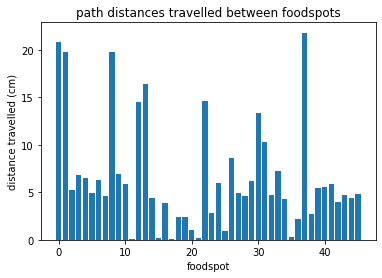

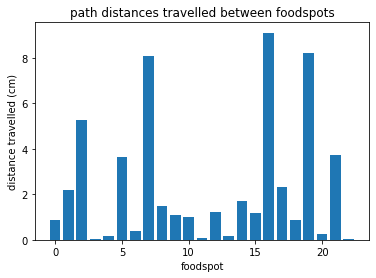

0.06610229153909492


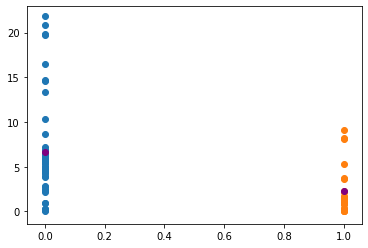

In [108]:
print(all_fly_food_path_distances)
for fly_index in range(len(all_fly_food_path_distances)):
    plt.bar(range(len(all_fly_food_path_distances[fly_index])), np.array(all_fly_food_path_distances[fly_index])*100)
    plt.title('path distances travelled between foodspots')
    plt.xlabel('foodspot')
    plt.ylabel('distance travelled (cm)')
    plt.show()
for fly_index in range(len(all_fly_food_path_distances)):
    plt.scatter(np.ones(len(all_fly_food_path_distances[fly_index]))*fly_index, np.array(all_fly_food_path_distances[fly_index])*100)
    plt.scatter(fly_index, np.mean(all_fly_food_path_distances[fly_index])*100, color = 'purple')
print(np.mean(all_fly_food_path_distances[0]))

(86367, 51)
4
86367
[31742 31743 31744 ... 84798 84799 84800]
[ 0  0  0 ... 23 23 23]


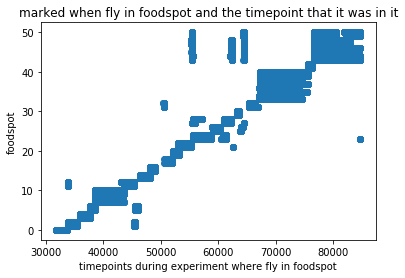

In [40]:
print(np.shape(all_fly_foodspot_bool[3]))
print(fly_index)
print(len(all_fly_foodspot_bool[3]))
print(where_true[0])
print(where_true[1])
plt.scatter(where_true[0], where_true[1])
plt.xlabel('timepoints during experiment where fly in foodspot')
plt.ylabel('foodspot')
plt.title('marked when fly in foodspot and the timepoint that it was in it')
##there are some timepoints where the fly is in multiple foodspots...see if those foodspots are in the same location
   # otherwise they must just be very close together (<foodspot radius apart)
plt.show()

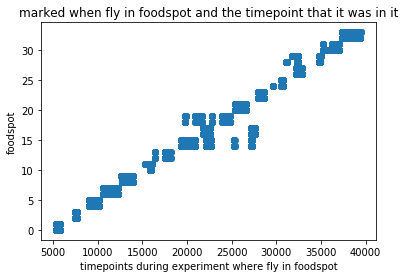

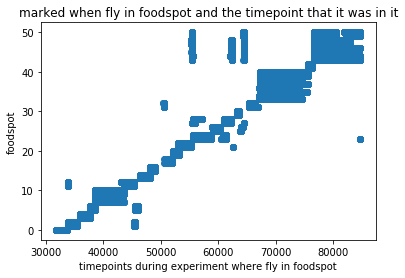

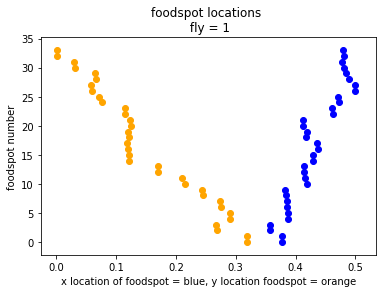

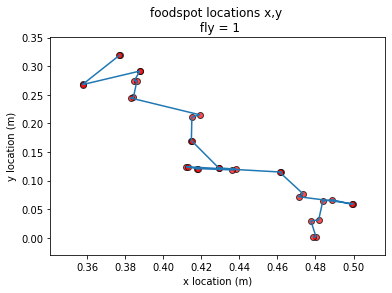

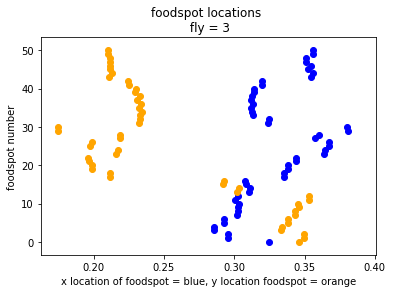

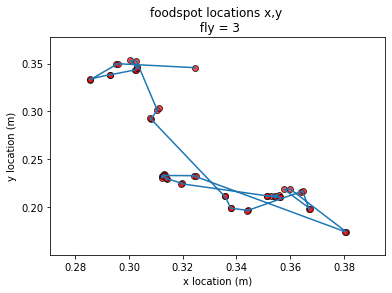

In [41]:
for fly_index in range(len(all_fly_foodspot_true_matrix)):
    if len(all_fly_foodspot_true_matrix[fly_index]) > 0:
        plt.scatter(all_fly_foodspot_true_matrix[fly_index][0], all_fly_foodspot_true_matrix[fly_index][1])
        plt.xlabel('timepoints during experiment where fly in foodspot')
        plt.ylabel('foodspot')
        plt.title('marked when fly in foodspot and the timepoint that it was in it')
        plt.show()

#see how close together dif foodspos are
for fly_index in range(len(flies)):  
    if flies[fly_index].optofoodx is not None and len(flies[fly_index].optofoodx) > 0:
        plt.scatter(flies[fly_index].optofoodx, range(len(flies[fly_index].optofoodx)), color = 'blue')
        plt.scatter(flies[fly_index].optofoody, range(len(flies[fly_index].optofoody)), color = 'orange')
        plt.title(f'foodspot locations \n fly = {fly_index}')
        plt.ylabel('foodspot number')
        plt.xlabel('x location of foodspot = blue, y location foodspot = orange')
        plt.show()
        plt.scatter(flies[fly_index].optofoodx, flies[fly_index].optofoody, color = 'red', alpha = .7, edgecolors = 'black')
        plt.plot(flies[fly_index].optofoodx, flies[fly_index].optofoody)
        plt.title(f'foodspot locations x,y \n fly = {fly_index}')
        plt.xlabel('x location (m)')
        plt.ylabel('y location (m)')
        plt.show()
        
        

    #how do I handle foodspots that are very close together? one mega foodspot?
    #yes. 
    # find foodspot clusters (If within fooddpot radius -> group)
    # find furthest x,y positions for the mega foodspot
    # will this give me the results I want?
    # what if I decide to not do this...
    # could wait until out of any foodspot radius if in many (maybe start with this)

In [50]:
##previously calculated the distance from each foodspot to every other foodspot
print(np.shape(all_fly_foodspot_distances_matrix))
appended_close_foodspots = []
for fly_index in range(len(all_fly_foodspot_distances_matrix)):
    if len(all_fly_foodspot_distances_matrix[fly_index]) > 0:
        print(type(all_fly_foodspot_distances_matrix[fly_index]))
        print(np.shape(all_fly_foodspot_distances_matrix[fly_index]))
        foodspot_distance_matrix = np.array(all_fly_foodspot_distances_matrix[fly_index])
        close_foodspots = foodspot_distance_matrix < foodspot_radius
        appended_close_foodspots.append(close_foodspots)


(5,)
<class 'list'>
(34, 34)
<class 'list'>
(51, 51)


(2,)
(34, 34)


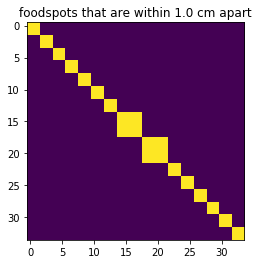

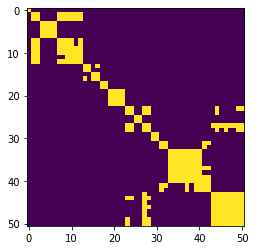

In [56]:
print(np.shape(appended_close_foodspots))
print(np.shape(appended_close_foodspots[0]))
plt.imshow(appended_close_foodspots[0])
plt.title(f'foodspots that are within {foodspot_radius*100} cm apart')
plt.show()
plt.imshow(appended_close_foodspots[1])

In [13]:
#calculate total distance travelled (using euclidian distance)
#euclidian distance between two points and then add to runnning sum
appended_total_distances = []

flies = [Fly(trial, sigma=3) for trial in trials]
for fly_index in range(len(flies)):  
    if flies[fly_index].x is not None:
        #for each fly, loop through all the positions. calculate the euc distance between the first and second and then second and third, etc
        #and sum
        #can I do this with slicing? is that what it is called? []-[]-1
        #[begin:end:stride] end is exclusive so if you want to include item #n write n+1. -1 is second to last

        #have the distances be adjusted so the first position = 0,0
        adj_x_positions = np.array(flies[fly_index].x) - flies[fly_index].x[0]
        adj_y_positions = np.array(flies[fly_index].y) - flies[fly_index].y[0]

        #calculate euclidian distance between each two points
        intermediate_distances_array = np.sqrt((abs(adj_x_positions[:-1]) - abs(adj_x_positions[1:]))**2 +
                                              (abs(adj_y_positions[:-1]) - abs(adj_y_positions[1:]))**2)
        #sum all of the distances
        total_distance = np.sum(intermediate_distances_array)
        appended_total_distances.append(total_distance)
    
    
print(appended_total_distances)

#save distances

distancesPath = SavePath + "/distances/"
if os.path.exists(distancesPath):
    print('folder there')
else:
    os.makedirs(distancesPath)
# np.savetxt(os.path.join(distancesPath, str(experiment) + '_' + str(genotype)+ '_' + str(condition) + 'total_distances_somewithoutfoodspots.csv'), appended_total_distances)

[0.0693867206274556, 3.7693107061526634, 0.005593399902503409, 1.5709508785102921]


[2.8299973011016846, 397.90962052345276, 11.859988689422607, 863.6591763496399]


<BarContainer object of 4 artists>

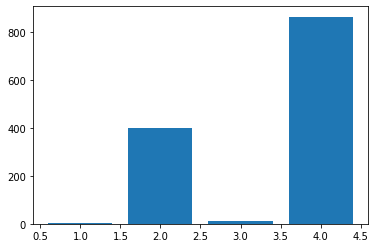

In [9]:
#total time
appended_total_durations = []
fly_index_appended = []
flies = [Fly(trial, sigma=3) for trial in trials]
for fly_index in range(len(flies)):
    if flies[fly_index].x is not None:
        duration = []
        duration = flies[fly_index].t[-1]-flies[fly_index].t[0]
        appended_total_durations.append(duration)
        fly_index_appended.append(fly_index+1)
print(appended_total_durations)

#save distances

durationsPath = SavePath + "/durations/"
if os.path.exists(durationsPath):
    print('folder there')
else:
    os.makedirs(durationsPath)
# np.savetxt(os.path.join(durationsPath, str(experiment) + '_' + str(genotype)+ '_' + str(condition) + 'total_durations_somewithoutfoodspots.csv'), appended_total_durations)

plt.bar(fly_index_appended, appended_total_durations)

In [10]:
800/60

13.333333333333334

[0.016800039236790392, 0.3632372980112824, 0.003201213442439159, 0.16692696475102511]
folder there


<BarContainer object of 4 artists>

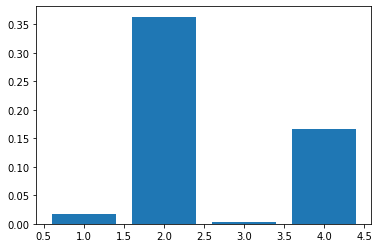

In [8]:
#furthest point from center
#straight line from center to point out (not path walked)
    #1. calculate distance from center for all points
    #2. find max value
appended_furthest_point = []
fly_index_appended = []
flies = [Fly(trial, sigma=3) for trial in trials]
for fly_index in range(len(flies)): 
    if flies[fly_index].x is not None:
        #euclidian distances from center and find max

        #have the distances be adjusted so the first position = 0,0
        adj_x_positions = np.array(flies[fly_index].x) - flies[fly_index].x[0]
        adj_y_positions = np.array(flies[fly_index].y) - flies[fly_index].y[0]

        #calculate euclidian distance between each two points
        intermediate_distances_array = np.sqrt((abs(adj_x_positions[:-1]) -0)**2 +
                                              (abs(adj_y_positions[:-1]) - 0)**2)
        #find max distance
        max_distance = np.max(intermediate_distances_array)
        appended_furthest_point.append(max_distance)

        fly_index_appended.append(fly_index+1)
    
print(appended_furthest_point)

#save distances

distancesPath = SavePath + "/distances/"
if os.path.exists(distancesPath):
    print('folder there')
else:
    os.makedirs(distancesPath)
# np.savetxt(os.path.join(distancesPath, str(experiment) + '_' + str(genotype)+ '_' + str(condition) + 'furthest_point_from_center_somewithoutfoodspots.csv'), appended_furthest_point)



plt.bar(fly_index_appended, appended_furthest_point)

[0.12443463 0.12666244 0.14354815 0.16759336 0.18237566 0.18683399
 0.21891693 0.22206009 0.24230677 0.25339119 0.25586445 0.29039445
 0.31260299 0.31311127 0.31892575 0.34997075 0.36180734 0.36971012
 0.37178007 0.37799652 0.38227408 0.38730239 0.4005427  0.41394608
 0.4159171  0.4305009  0.43108742 0.47602377 0.48008946 0.49496405
 0.5003421 ]


<BarContainer object of 31 artists>

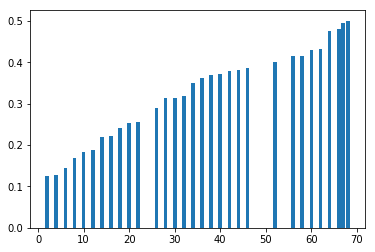

In [21]:
sorted_appended_furthest_point = np.sort(appended_furthest_point)

print(sorted_appended_furthest_point)
plt.bar(fly_index_appended, sorted_appended_furthest_point)

('fly index with fewer than 2 foodspots', 1)
('fly index with fewer than 2 foodspots', 3)
('fly index with fewer than 2 foodspots', 5)
('fly index with more than one foodspot', 7)
('fly index with more than one foodspot', 9)
('fly index with fewer than 2 foodspots', 11)
('fly index with more than one foodspot', 13)
('fly index with more than one foodspot', 15)
('fly index with more than one foodspot', 17)
('fly index with fewer than 2 foodspots', 19)
('fly index with more than one foodspot', 21)
('fly index with more than one foodspot', 25)
('fly index with more than one foodspot', 27)
('fly index with more than one foodspot', 29)
('fly index with more than one foodspot', 31)
('fly index with more than one foodspot', 33)
('fly index with more than one foodspot', 35)
('fly index with fewer than 2 foodspots', 37)
('fly index with fewer than 2 foodspots', 39)
('fly index with more than one foodspot', 41)
('fly index with more than one foodspot', 43)
('fly index with more than one foodspot

<BarContainer object of 31 artists>

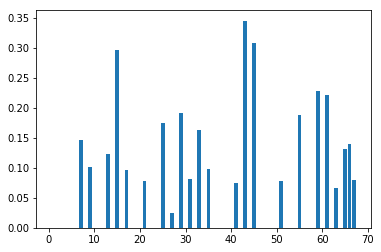

In [23]:
##distance between foodspots
#the direct distance between two foodspots NOT the path the fly took

flies = [Fly(trial, sigma=3) for trial in trials]
distances_between_foodspots_appended = []
fly_index_appended = []
mean_distances_appended = []
for fly_index in range(len(flies)):
    if flies[fly_index].x is not None:
        if len(flies[fly_index].optofoodx) > 1:
            print('fly index with more than one foodspot', fly_index)
            center_x = flies[fly_index].x[0]
            center_y = flies[fly_index].y[0]

            adj_optox_positions = np.array(flies[fly_index].optofoodx) - center_x
            adj_optoy_positions = np.array(flies[fly_index].optofoody) - center_y

            #calculate euclidian distance between each two points
            intermediate_distances_array = np.sqrt((abs(adj_optox_positions[:-1]) - abs(adj_optox_positions[1:]))**2 +
                                                  (abs(adj_optoy_positions[:-1]) - abs(adj_optoy_positions[1:]))**2)
            #calculate mean
            mean_distances = np.mean(intermediate_distances_array)

        #if there are no foodspots
        else: 
            print('fly index with fewer than 2 foodspots', fly_index)
            intermediate_distances_array = np.array([0])
            #calculate mean
            mean_distances = np.mean(intermediate_distances_array)

        #append the arrays of distances
        distances_between_foodspots_appended.append(intermediate_distances_array)
        fly_index_appended.append(fly_index)
        mean_distances_appended.append(mean_distances)

print(distances_between_foodspots_appended)
print(len(distances_between_foodspots_appended))
#print(np.shape(distances_between_foodspots_appended))
print(distances_between_foodspots_appended[2])


distances_between_foodspots_appended = np.array(distances_between_foodspots_appended)
print(fly_index_appended)
print(mean_distances_appended)

# header_video_info = ['date', 'video-number', 'framerate', 'threshold', 'interval-length', 'probe-length', '#light-pulses', '#probe-trials', 'length of video']
# video_name = str(video).strip('[]')
# video_info = [date, video_name, framerate, smoothed_threshold, light_interval_time, probe_length_time, number_of_pulses, number_probe_trials, length_video]
# all_video_info = [header_video_info, video_info]
# np.savetxt(os.path.join(videoinfopath, date + str(video).strip('[]') + 'all_video_info.txt'), all_video_info, fmt='%s')


foodspotsPath = SavePath + "/foodspots/"
if os.path.exists(foodspotsPath):
    print('folder there')
else:
    os.makedirs(foodspotsPath)


# np.savetxt(os.path.join(foodspotsPath, str(experiment) + '_' + str(genotype)+ '_' + str(condition) + 'distance_between_foodspots.csv'), distances_between_foodspots_appended,  fmt='%s', delimiter = ',')
# np.savetxt(os.path.join(foodspotsPath, str(experiment) + '_' + str(genotype)+ '_' + str(condition) + 'mean_distance_between_foodspots.csv'), mean_distances_appended,  fmt='%s', delimiter = ',')

plt.bar(fly_index_appended, mean_distances_appended)

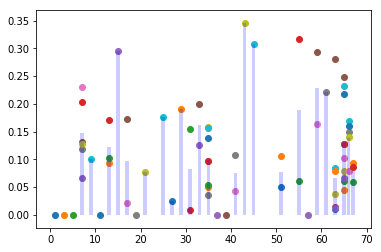

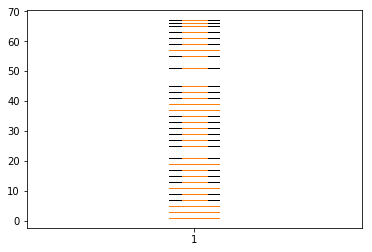

In [24]:
#plot mean distances between foodspots for each fly 
plt.bar(fly_index_appended, mean_distances_appended, color = 'blue', alpha = .2)
for fly in range(len(distances_between_foodspots_appended)):
    
    for i in range(len(distances_between_foodspots_appended[fly])):
        plt.scatter(fly_index_appended[fly], distances_between_foodspots_appended[fly][i])
plt.show()


for fly in range(len(distances_between_foodspots_appended)):
    for i in range(len(distances_between_foodspots_appended[fly])):
        plt.boxplot(fly_index_appended[fly], distances_between_foodspots_appended[fly][i])
plt.show()


[0.07165087705483113, 0.008900362035139674, 0.016040567358521194, 0.13547018186886078, 0.023366723579155167, 0.03835119775761292, 0.1411785654429914, 0.1292783902362125, 0.1442103364996694, 0.01752690186549748, 0.028718640549718517, 0.04678855266104364, 0.06508376069174966, 0.20262608649733047, 0.07532456295448023, 0.17198095234809327, 0.14167948389938861, 0.10706586116500437, 0.06492190826055409, 0.06307748532225478, 0.07383977960315548, 0.07025051376069597, 0.032124787919361394, 0.11781489519997346, 0.049530678678249784, 0.2077440733361481, 0.08522179315734757, 0.14824360178854892, 0.3284159022342053, 0.22284830881312284, 0.03185045032848994]
31
31
[0.11859737354039851, 0.000795563378038211, 0.001381465678758631, 0.3129939610215914, 0.024153063550300446, 0.1101329550297192, 0.24820111988357046, 0.3180709574345105, 0.36331532840452435, 0.05256876780530856, 0.051233819027399485, 0.05281954020318119, 0.17307389858003175, 0.3731100285538582, 0.11017078874203134, 0.13263294016256194, 0.19

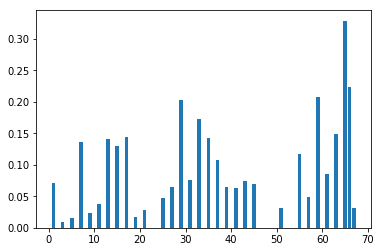

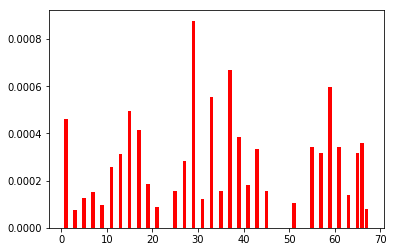

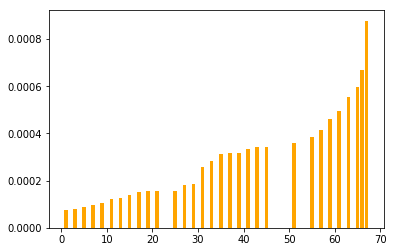

In [28]:
##total area travelled (calculated as rectangle around furthest points in each direction)

rectangle_area_appended = []
appended_max_x = []
appended_max_y = []
appended_min_x = []
appended_min_y = []

flies = [Fly(trial, sigma=3) for trial in trials]
for fly_index in range(len(flies)):
    if flies[fly_index].x is not None:
        #euclidian distances from center and find max

        #have the distances be adjusted so the first position = 0,0
        adj_x_positions = np.array(flies[fly_index].x) - flies[fly_index].x[0]
        adj_y_positions = np.array(flies[fly_index].y) - flies[fly_index].y[0]

        #find the max and min x and y positions to use as rectangle points
        max_x = np.max(adj_x_positions)
        max_y = np.max(adj_y_positions)
        min_x = np.min(adj_x_positions)
        min_y = np.min(adj_y_positions)

        appended_max_x.append(max_x)
        appended_max_y.append(max_y)
        appended_min_x.append(min_x)
        appended_min_y.append(min_y)

        #calculate the area of the rectangle
        length = abs(max_x - min_x)
        height = abs(max_y - min_y)
        rectangle_area = length * height

        rectangle_area_appended.append(rectangle_area)
print(rectangle_area_appended)
print(len(rectangle_area_appended))
print(len(fly_index_appended))
print(appended_max_x)

areaPath = SavePath + "/area/"
if os.path.exists(areaPath):
    print('folder there')
else:
    os.makedirs(areaPath)


# np.savetxt(os.path.join(areaPath, str(experiment) + '_' + str(genotype)+ '_' + str(condition) + 'rectangular_area_somewithoutfoodspots.csv'), rectangle_area_appended)

plt.bar(fly_index_appended, rectangle_area_appended)
normalized_area = np.array(rectangle_area_appended)/np.array(appended_total_durations)
plt.show()
plt.bar(fly_index_appended, normalized_area, color = 'red')
plt.show()

sorted_normalized = np.sort(normalized_area)
plt.bar(fly_index_appended, sorted_normalized, color = 'orange')
plt.show()

[0.056274467244680736, 0.006990327995971075, 0.012598232143235605, 0.10639803203492154, 0.018352181783684317, 0.03012096028292152, 0.1108813860100119, 0.1015350102584999, 0.11326253342976834, 0.013765596535209031, 0.02255556754302041, 0.03674764332800847, 0.05111666611429922, 0.15914215619141583, 0.059159773403164244, 0.13507352411353651, 0.11127480644567818, 0.08408933072156062, 0.05098954751209681, 0.049540941123828404, 0.057993627285990675, 0.05517462448537778, 0.025230749431398976, 0.092531602310922, 0.03890130406572654, 0.16316181365491553, 0.06693303982721802, 0.116430252580149, 0.25793724644526084, 0.17502465245805407, 0.025015285191377655]
folder there


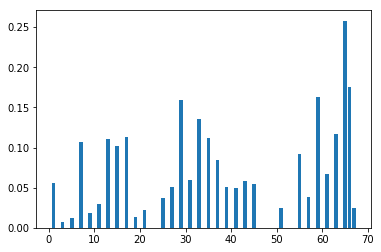

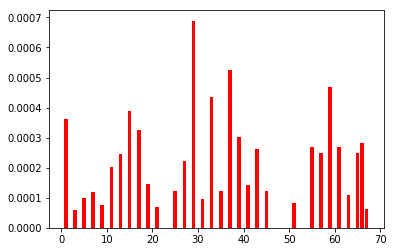

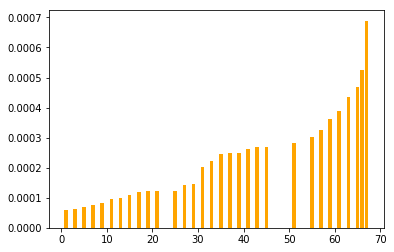

In [27]:
##total area travelled (calculated as an ellipse around furthest points in each direction--not diagonal)

ellipse_area_appended = []
flies = [Fly(trial, sigma=3) for trial in trials]
for fly_index in range(len(flies)):  
    if flies[fly_index].x is not None:
        #euclidian distances from center and find max

        #have the distances be adjusted so the first position = 0,0
        adj_x_positions = np.array(flies[fly_index].x) - flies[fly_index].x[0]
        adj_y_positions = np.array(flies[fly_index].y) - flies[fly_index].y[0]

        #find the max and min x and y positions to use as rectangle points
        max_x = np.max(adj_x_positions)
        max_y = np.max(adj_y_positions)
        min_x = np.min(adj_x_positions)
        min_y = np.min(adj_y_positions)

        #calculate the area of the ellipse (untilted)
        length = abs(max_x - min_x)
        height = abs(max_y - min_y)
        x_radius = length/2
        y_radius = height/2
        ellipse_area = math.pi * x_radius * y_radius

        ellipse_area_appended.append(ellipse_area)
print(ellipse_area_appended)

areaPath = SavePath + "/area/"
if os.path.exists(areaPath):
    print('folder there')
else:
    os.makedirs(areaPath)


# np.savetxt(os.path.join(areaPath, str(experiment) + '_' + str(genotype)+ '_' + str(condition) + 'ellipse_area.csv'), rectangle_area_appended)

plt.bar(fly_index_appended, ellipse_area_appended)
normalized_area = np.array(ellipse_area_appended)/np.array(appended_total_durations)
plt.show()
plt.bar(fly_index_appended, normalized_area, color = 'red')
plt.show()

sorted_normalized = np.sort(normalized_area)
plt.bar(fly_index_appended, sorted_normalized, color = 'orange')
plt.show()

In [15]:
# Schmitt trigger logic (from Roman-Dickinson lab)
# revisit_near is the inner distance threshold
# revisit_away is the outer distance threshold
# stimX & stimY is the fictive food location
# x & y are the arrays of fly positions


def count_revisits(stimX,stimY,x,y):
    
    # get all radial values
    radials=np.zeros(len(x))
    for i in range(len(x)):
        posx=x[i]
        posy=y[i]
        # find radial distance
        x_dist=posx-stimX
        y_dist=posy-stimY
        dist = np.array([x_dist, y_dist])
        radials[i] = np.hypot(x_dist, y_dist)
        
    # get each leave and return
    revisit_away = .01 #how far away it needs to get
    revisit_near = .005 #how close it needs to get
    starts = []
    ends = []
    near_state = True # if fly is on food
    away_state = False # if fly has walked away from food
    revisits=0
    for i in range(len(radials)):
        r=radials[i]
        if away_state==False:
            if r>revisit_away:
                starts.append(i)
                away_state=True
                near_state=False
        elif near_state==False:
            if r<revisit_near:
                ends.append(i)
                near_state=True
                away_state=False
    if len(starts)>len(ends):
        starts.pop()
    revisits=len(starts)
    return revisits

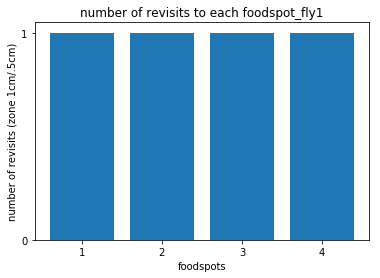

In [159]:
##PLOT REVISITS #######



# flies = [Fly(trial, sigma=3) for trial in trials]
# for fly in flies: 
#     #print(len(fly.optofoodx))
#     #print(fly.optofoodx)

flies = [Fly(trial, sigma=3) for trial in trials]
revisits = []
for fly in flies: 
    revisits_each_fly = []
    for i in range(len(fly.optofoodx)):
        revisits_each_fly.append(count_revisits(fly.optofoodx[i],fly.optofoody[i],fly.x,fly.y))
    revisits.append(revisits_each_fly)
#print(revisits)

foodspot_locations = []
for fly in flies:
    foodspot_locations = fly.optofoodx - fly.x[0]
    #print(fly.optofoodx)
#print(foodspot_locations*100)


# print(len(revisits))
# #print('test', len(revisits[4]))
# for i in range(len(revisits)):
#     if len(revisits[i]) > 0:
#         #print(i)

for i in range(len(revisits)):
    if len(revisits[i]) >0:
        plt.title('number of revisits to each foodspot' + '_fly' + str(i+1))
        plt.xlabel('foodspots')
        plt.ylabel('number of revisits (zone 1cm/.5cm)')

        plt.yticks(range(0, max(revisits[i])+1))
        plt.xticks(range(1, len(revisits[i])+1))

        #plt.xlim(0, len(revisits[i]), 1)
        plt.bar(range(1, len(revisits[i])+1), revisits[i])
#         plt.savefig(os.path.join(SavePath, str(experiment) + '_' + str(genotype)+ '_' + str(condition) + 'fly ' + str(i+1) + '_REVISITS.png'))
        plt.show()

[-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01
  1.00000000e+00  1.10000000e+00  1.20000000e+00  1.30000000e+00
  1.40000000e+00  1.50000000e+00  1.60000000e+00  1.70000000e+00
  1.80000000e+00  1.90000000e+00  2.00000000e+00  2.10000000e+00
  2.20000000e+00  2.30000000e+00  2.40000000e+00  2.50000000e+00
  2.60000000e+00  2.70000000e+00  2.80000000e+00  2.90000000e+00
  3.00000000e+00  3.10000000e+00  3.20000000e+00  3.30000000e+00
  3.40000000e+00  3.50000000e+00  3.60000000e+00  3.70000000e+00
  3.80000000e+00  3.90000000e+00  4.00000000e+00  4.10000000e+00
  4.20000000e+00  4.30000000e+00  4.40000000e+00  4.50000000e+00
  4.60000000e+00  4.70000000e+00  4.80000000e+00  4.90000000e+00
  5.00000000e+00  5.10000

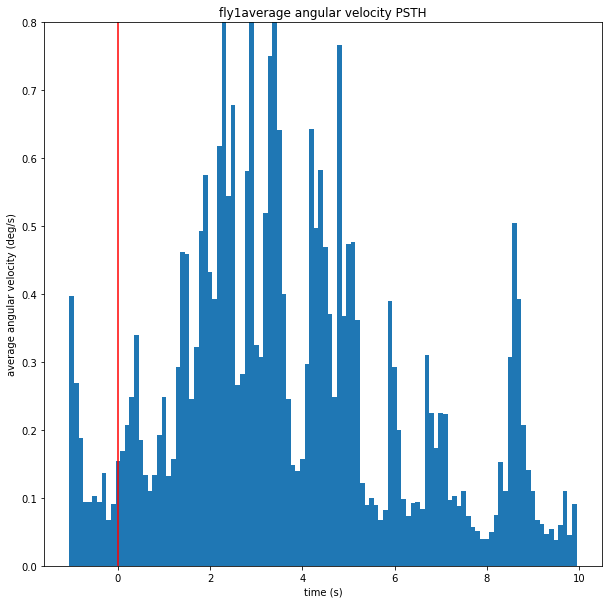

[-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01
  1.00000000e+00  1.10000000e+00  1.20000000e+00  1.30000000e+00
  1.40000000e+00  1.50000000e+00  1.60000000e+00  1.70000000e+00
  1.80000000e+00  1.90000000e+00  2.00000000e+00  2.10000000e+00
  2.20000000e+00  2.30000000e+00  2.40000000e+00  2.50000000e+00
  2.60000000e+00  2.70000000e+00  2.80000000e+00  2.90000000e+00
  3.00000000e+00  3.10000000e+00  3.20000000e+00  3.30000000e+00
  3.40000000e+00  3.50000000e+00  3.60000000e+00  3.70000000e+00
  3.80000000e+00  3.90000000e+00  4.00000000e+00  4.10000000e+00
  4.20000000e+00  4.30000000e+00  4.40000000e+00  4.50000000e+00
  4.60000000e+00  4.70000000e+00  4.80000000e+00  4.90000000e+00
  5.00000000e+00  5.10000

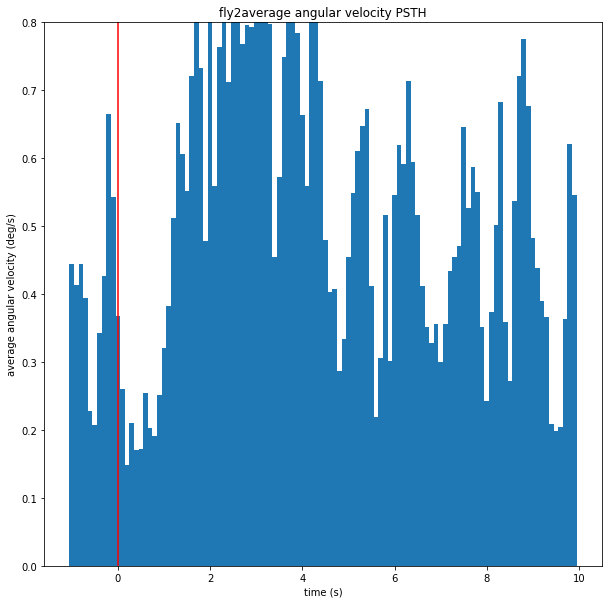

[-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01
  1.00000000e+00  1.10000000e+00  1.20000000e+00  1.30000000e+00
  1.40000000e+00  1.50000000e+00  1.60000000e+00  1.70000000e+00
  1.80000000e+00  1.90000000e+00  2.00000000e+00  2.10000000e+00
  2.20000000e+00  2.30000000e+00  2.40000000e+00  2.50000000e+00
  2.60000000e+00  2.70000000e+00  2.80000000e+00  2.90000000e+00
  3.00000000e+00  3.10000000e+00  3.20000000e+00  3.30000000e+00
  3.40000000e+00  3.50000000e+00  3.60000000e+00  3.70000000e+00
  3.80000000e+00  3.90000000e+00  4.00000000e+00  4.10000000e+00
  4.20000000e+00  4.30000000e+00  4.40000000e+00  4.50000000e+00
  4.60000000e+00  4.70000000e+00  4.80000000e+00  4.90000000e+00
  5.00000000e+00  5.10000

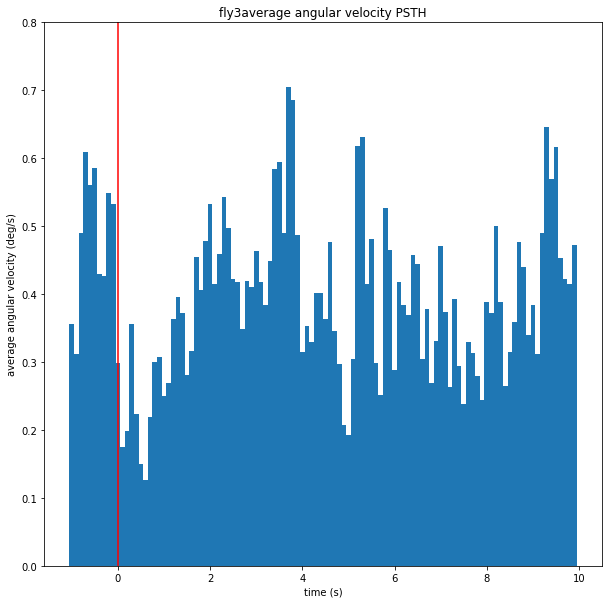

In [9]:
#plot angular velocity vs. time light goes on
#PSTH

flies = [Fly(trial, sigma=3) for trial in trials]
#flies = [Fly(trial, sigma=3) for trial in trials][1:]  #to get rid of super long first fly in wt


fly_index = 0
for fly in flies:
    fly_index = fly_index + 1 
#     print(fly.optot)
#     print(fly.optoON)
    #print(fly.optostatus)
    fly.velocity()
    angular_velocity = fly.av
    times = fly.t
    #print(angular_velocity)
    
    #time doesn't start at 0 so adjust
    adjusted_time = []
    for time in range(len(fly.t)):
        each_adjusted_time = []
        each_adjusted_time = fly.t[time]-fly.t[0]
        adjusted_time.append(each_adjusted_time)
    adjusted_optoON = []
    for time in range(len(fly.optoON)):
        each_adjusted_time = []
        each_adjusted_time = fly.optoON[time] - fly.t[0]
        adjusted_optoON.append(each_adjusted_time)

    #make PSTH
    #split data subtract time of light on from times of velocity if more than time of light on
    #do it after the first light pulse
    #need to keep track of velocity and time together
        #have it collect a list of indices that i can use to plot the right velocities?
    #make sure only collect from region where data is-opto keeps going
        #max(ajdusted_time[:-2] is the max time)
        #if i set it up to look throuhg data times then it should be fine
    
    #have two things--time after light goes on and velocity value
        #could do just movement > threshold vs. time after stim
        #could do average abs velcoity for time between stims or within 3s of stim
        
    #take -1 to 10s where 0 is the light goes on and calculate the average angualr velocity for each .1s bin
    #np.linspace to make bins
    #np.where to find indices
    bin_size = .1
    bins = np.arange(-1.0,10.0,bin_size)
    print(bins)
    
    bin_values = np.zeros_like(bins)
    bin_counts = np.zeros_like(bin_values)
    for bin_index, this_bin in enumerate(bins):
        for this_light_on in adjusted_optoON:
            this_min = this_bin + this_light_on
            this_max = this_bin + this_light_on + bin_size
            av_timestamp_indices = np.where(np.logical_and(adjusted_time[:-2] >= this_min,
                                                           adjusted_time[:-2] < this_max))[0]
            if av_timestamp_indices.size > 0:
                av_values = abs(angular_velocity[av_timestamp_indices])
                #print(av_values)
                bin_value = np.mean(av_values) # or np.median
                if np.isnan(bin_value):
                    print("nan",av_values, av_timestamp_indices)
                #print(bin_value)
                bin_values[bin_index] += bin_value
                bin_counts[bin_index] += 1
                
    bin_averages = bin_values / bin_counts
    #plt.plot(bin_averages)
    fig1 = plt.figure(figsize=(10, 10))
    plt.bar(bins, bin_averages, width=0.1)  #larger 0.4
    plt.axvline(x=0, color = 'red')
    plt.ylim(0,.8)
    plt.xlabel('time (s)')
    plt.ylabel('average angular velocity (deg/s)')
    plt.title('fly' + str(fly_index) + 'average angular velocity PSTH')
#     plt.savefig(os.path.join(SavePath, 'PSTH_angular_velocity_flyYLIM-100msbin'+str(fly_index) + '_' + str(genotype)+ '_' + '.png'))
    plt.show()

                
        
        

    #plt.hist(data, bins)
    
    
#     #plt.plot(fly.t[:-2], fly.av)
#     fig1 = plt.figure(figsize=(10, 10))
#     plt.plot(adjusted_time[:-2], fly.av)
#     #plot times light on as vertical bars
#     for i in range(len(adjusted_optoON)):
#         plt.axvline(x=adjusted_optoON[i], color = 'red')
#     plt.title('fly' + str(fly_index) + 'relative time')
#     plt.xlim(0, max(adjusted_time[:-2]))
#     plt.savefig(os.path.join(SavePath, 'angular_velocity_relativeTime_fly'+str(fly_index) + '_' + str(genotype)+ '_' + '.png'))
#     plt.savefig(os.path.join(SavePath, 'angular_velocity_relativeTime_fly'+str(fly_index) + '_' + str(genotype)+ '_' + '.svg'))
#     plt.show()
        
    
#     fig2 = plt.figure(figsize=(10, 10))
#     ##un-adjusted
#     plt.plot(fly.t[:-2], fly.av)
#     #plot times light on as vertical bars
#     for i in range(len(fly.optoON)):
#         plt.axvline(x=fly.optoON[i], color = 'red')
#     plt.title('fly' + str(fly_index) + 'absolute time')
#     plt.xlim(min(fly.t[:-2]), max(fly.t[:-2]))
#     plt.savefig(os.path.join(SavePath, 'angular_velocity_fly'+str(fly_index) + '_' + str(genotype)+ '_' + '.png'))
#     plt.savefig(os.path.join(SavePath, 'angular_velocity_fly'+str(fly_index) + '_' + str(genotype)+ '_' + '.svg'))
#     plt.show()
    
    #plt.scatter(adjusted_optoON, [0]*len(adjusted_optoON))


# control_average_angular_velocity = []
# control_total_angular_velocity = []
# control_all_fly_velocity = []
# for fly in fliesControl:
#     control_single_velocity = []
#     fly.velocity()
#     control_single_velocity_sum = sum(abs(fly.av))#I think I need the absolute value because can have negative velocity and I don't care
#     control_time_in_arena_by_fly = max(fly.t)-min(fly.t)
#     print('time', control_time_in_arena_by_fly)
#     control_ang_veloc_by_time_by_fly = control_single_velocity_sum/control_time_in_arena_by_fly
#     control_all_fly_velocity.append(control_ang_veloc_by_time_by_fly)
    
# control_total_flies = len(flies)
# control_total_angular_velocity = sum(control_all_fly_velocity)
# control_average_angular_velocity = control_total_angular_velocity/control_total_flies 


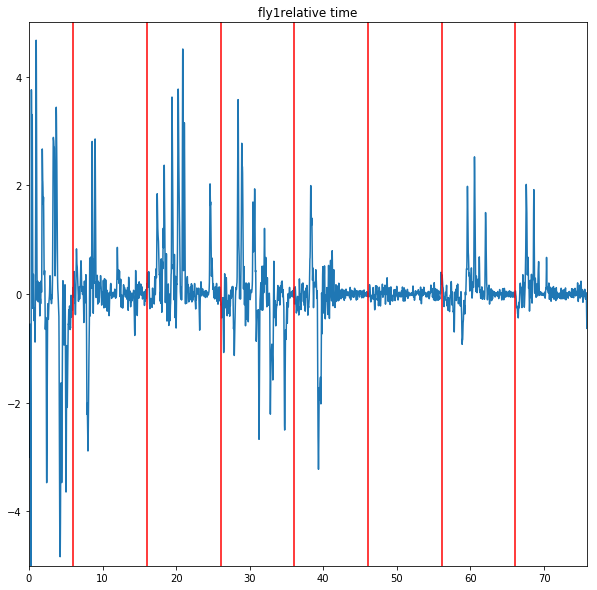

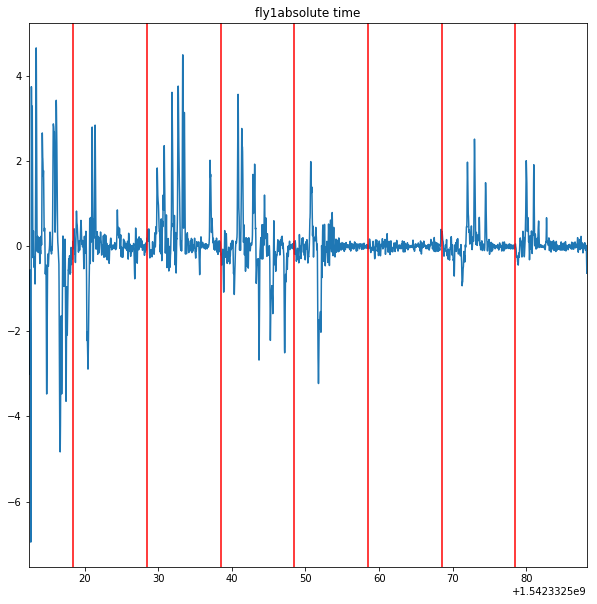

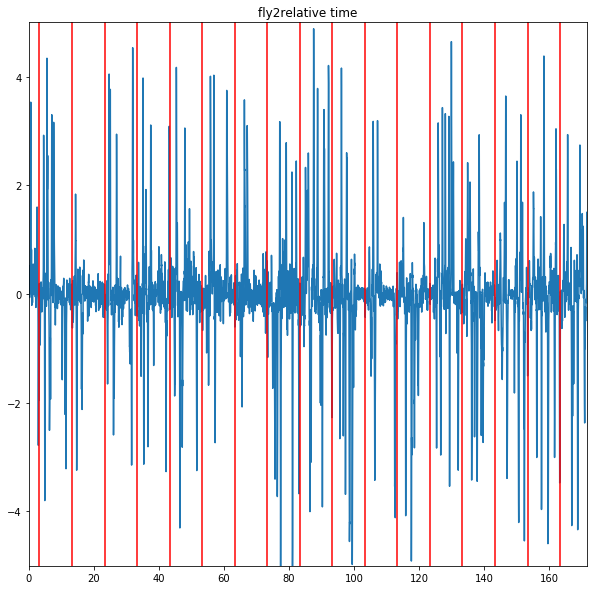

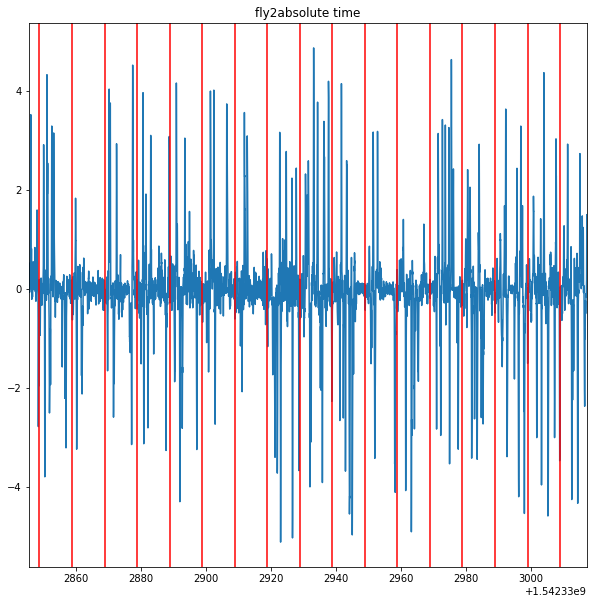

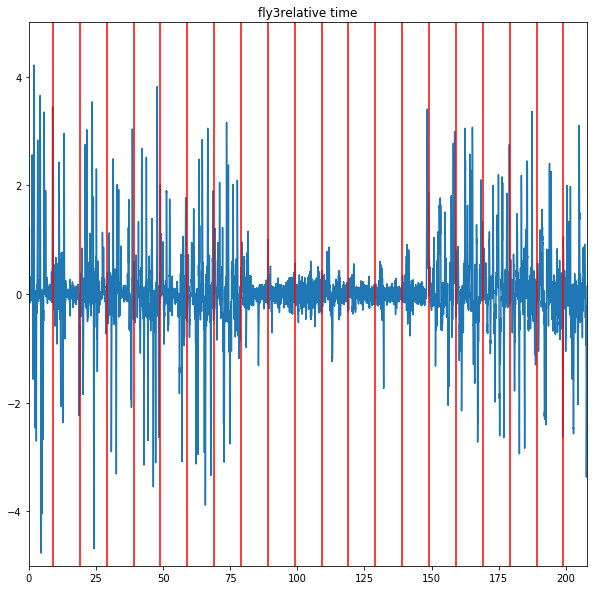

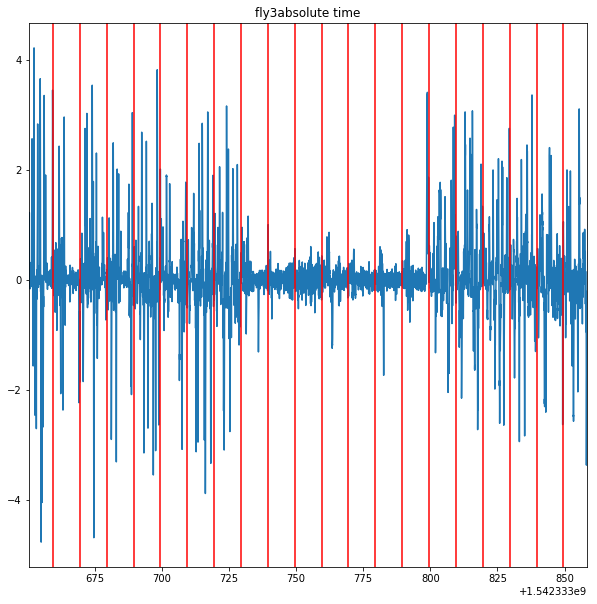

In [6]:
#plot angular velocity vs. time light goes on

flies = [Fly(trial, sigma=3) for trial in trials]
#flies = [Fly(trial, sigma=3) for trial in trials][1:]  #to get rid of super long first fly in wt


fly_index = 0
for fly in flies:
    fly_index = fly_index + 1 
#     print(fly.optot)
#     print(fly.optoON)
    #print(fly.optostatus)
    fly.velocity()
    angular_velocity = fly.av
    times = fly.t
    #print(angular_velocity)
    adjusted_time = []
    for time in range(len(fly.t)):
        each_adjusted_time = []
        each_adjusted_time = fly.t[time]-fly.t[0]
        adjusted_time.append(each_adjusted_time)
    adjusted_optoON = []
    for time in range(len(fly.optoON)):
        each_adjusted_time = []
        each_adjusted_time = fly.optoON[time] - fly.t[0]
        adjusted_optoON.append(each_adjusted_time)

    
    
    #plt.plot(fly.t[:-2], fly.av)
    fig1 = plt.figure(figsize=(10, 10))
    plt.plot(adjusted_time[:-2], fly.av)
    #plot times light on as vertical bars
    for i in range(len(adjusted_optoON)):
        plt.axvline(x=adjusted_optoON[i], color = 'red')
    plt.title('fly' + str(fly_index) + 'relative time')
    plt.xlim(0, max(adjusted_time[:-2]))
    plt.ylim(-5,5)
    plt.savefig(os.path.join(SavePath, 'angular_velocity_relativeTimeYlim_fly'+str(fly_index) + '_' + str(genotype)+ '_' + '.png'))
    plt.savefig(os.path.join(SavePath, 'angular_velocity_relativeTimeYlim_fly'+str(fly_index) + '_' + str(genotype)+ '_' + '.svg'))
    plt.show()
        
    
#     fig2 = plt.figure(figsize=(10, 10))
#     ##un-adjusted
#     plt.plot(fly.t[:-2], fly.av)
#     #plot times light on as vertical bars
#     for i in range(len(fly.optoON)):
#         plt.axvline(x=fly.optoON[i], color = 'red')
#     plt.title('fly' + str(fly_index) + 'absolute time')
#     plt.xlim(min(fly.t[:-2]), max(fly.t[:-2]))
#     plt.savefig(os.path.join(SavePath, 'angular_velocity_fly'+str(fly_index) + '_' + str(genotype)+ '_' + '.png'))
#     plt.savefig(os.path.join(SavePath, 'angular_velocity_fly'+str(fly_index) + '_' + str(genotype)+ '_' + '.svg'))
#     plt.show()
    
    
    
    
    
    
    #plt.scatter(adjusted_optoON, [0]*len(adjusted_optoON))


# control_average_angular_velocity = []
# control_total_angular_velocity = []
# control_all_fly_velocity = []
# for fly in fliesControl:
#     control_single_velocity = []
#     fly.velocity()
#     control_single_velocity_sum = sum(abs(fly.av))#I think I need the absolute value because can have negative velocity and I don't care
#     control_time_in_arena_by_fly = max(fly.t)-min(fly.t)
#     print('time', control_time_in_arena_by_fly)
#     control_ang_veloc_by_time_by_fly = control_single_velocity_sum/control_time_in_arena_by_fly
#     control_all_fly_velocity.append(control_ang_veloc_by_time_by_fly)
    
# control_total_flies = len(flies)
# control_total_angular_velocity = sum(control_all_fly_velocity)
# control_average_angular_velocity = control_total_angular_velocity/control_total_flies 


#Fly arrow plots (Very slow to run)